Lambda School Data Science

*Unit 2, Sprint 1, Module 3*

---

# Ridge Regression

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

- [ ] Use a subset of the data where `BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'` and the sale price was more than 100 thousand and less than 2 million.
- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a ridge regression model with multiple features. Use the `normalize=True` parameter (or do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html) beforehand — use the scaler's `fit_transform` method with the train set, and the scaler's `transform` method with the test set)
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


## Stretch Goals

Don't worry, you aren't expected to do all these stretch goals! These are just ideas to consider and choose from.

- [ ] Add your own stretch goal(s) !
- [ ] Instead of `Ridge`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `Ridge`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [93]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [94]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv(DATA_PATH+'condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [95]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [96]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [97]:
pd.set_option('display.max_columns', None)

In [98]:
# Use a subset of the data where BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS' 
# and the sale price was more than 100 thousand and less than 2 million.

In [99]:
df = df[df.BUILDING_CLASS_CATEGORY == '01 ONE FAMILY DWELLINGS']

In [100]:
df = df[(df.SALE_PRICE > 100000) & (df.SALE_PRICE < 2000000)]

In [101]:
df

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019
61,4,OTHER,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23029,4,OTHER,01 ONE FAMILY DWELLINGS,1,13215,3,NaN,A2,244-15 135 AVENUE,NaN,11422.0,1.0,0.0,1.0,"3,300",1478.0,1925.0,1,A2,635000,04/30/2019
23031,4,OTHER,01 ONE FAMILY DWELLINGS,1,11612,73,NaN,A1,10919 132ND STREET,NaN,11420.0,1.0,0.0,1.0,"2,400",1280.0,1930.0,1,A1,514000,04/30/2019
23032,4,OTHER,01 ONE FAMILY DWELLINGS,1,11808,50,NaN,A0,135-24 122ND STREET,NaN,11420.0,1.0,0.0,1.0,"4,000",1333.0,1945.0,1,A0,635000,04/30/2019
23033,4,OTHER,01 ONE FAMILY DWELLINGS,1,12295,23,NaN,A1,134-34 157TH STREET,NaN,11434.0,1.0,0.0,1.0,"2,500",1020.0,1935.0,1,A1,545000,04/30/2019


In [102]:
df.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_CATEGORY',
       'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING_CLASS_AT_PRESENT', 'ADDRESS', 'APARTMENT_NUMBER', 'ZIP_CODE',
       'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'LAND_SQUARE_FEET', 'GROSS_SQUARE_FEET', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE',
       'SALE_PRICE', 'SALE_DATE'],
      dtype='object')

In [103]:
df.dtypes

BOROUGH                            object
NEIGHBORHOOD                       object
BUILDING_CLASS_CATEGORY            object
TAX_CLASS_AT_PRESENT               object
BLOCK                               int64
LOT                                 int64
EASE-MENT                         float64
BUILDING_CLASS_AT_PRESENT          object
ADDRESS                            object
APARTMENT_NUMBER                   object
ZIP_CODE                          float64
RESIDENTIAL_UNITS                 float64
COMMERCIAL_UNITS                  float64
TOTAL_UNITS                       float64
LAND_SQUARE_FEET                   object
GROSS_SQUARE_FEET                 float64
YEAR_BUILT                        float64
TAX_CLASS_AT_TIME_OF_SALE           int64
BUILDING_CLASS_AT_TIME_OF_SALE     object
SALE_PRICE                          int32
SALE_DATE                          object
dtype: object

In [104]:
# Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.

In [105]:
df['SALE_DATE'] = pd.to_datetime(df['SALE_DATE'], infer_datetime_format=True)

In [106]:
train = df[(df['SALE_DATE'] > '2019-01-01 00:00:00') & (df['SALE_DATE'] <= '2019-03-31 23:59:59')]

In [107]:
test = df[(df['SALE_DATE'] > '2019-04-01 00:00:00') & (df['SALE_DATE'] <= '2019-04-30 23:59:59')]

In [108]:
train.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
78,2,OTHER,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,2019-01-02
108,3,OTHER,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,2019-01-02
111,3,OTHER,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,2019-01-02
120,3,OTHER,01 ONE FAMILY DWELLINGS,1,6806,72,NaN,A1,1747 EAST 23RD STREET,NaN,11229.0,1.0,0.0,1.0,"4,000",1932.0,1930.0,1,A1,1150000,2019-01-02
121,3,OTHER,01 ONE FAMILY DWELLINGS,1,6761,42,NaN,A1,1582 EAST 15TH STREET,NaN,11230.0,1.0,0.0,1.0,"2,000",1722.0,1920.0,1,A1,836500,2019-01-02


In [109]:
train.describe()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,2505.000000,2505.000000,0.0,2505.000000,2505.000000,2505.000000,2505.000000,2505.000000,2505.000000,2505.0,2.505000e+03
mean,6758.345309,75.490220,NaN,10993.130938,0.987625,0.016367,1.003992,1473.593613,1944.774451,1.0,6.217706e+05
std,3977.348895,156.925935,NaN,494.390215,0.110576,0.130017,0.171863,599.356892,27.068364,0.0,2.915984e+05
min,21.000000,1.000000,NaN,10301.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,3830.000000,21.000000,NaN,10314.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.410000e+05
50%,6022.000000,42.000000,NaN,11234.000000,1.000000,0.000000,1.000000,1368.000000,1940.000000,1.0,5.600000e+05
75%,9898.000000,70.000000,NaN,11413.000000,1.000000,0.000000,1.000000,1683.000000,1960.000000,1.0,7.500000e+05
max,16350.000000,2720.000000,NaN,11697.000000,1.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,1.955000e+06


In [110]:
train.select_dtypes(include='number').describe()

,BLOCK,LOT,EASE-MENT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,SALE_PRICE
count,2505.000000,2505.000000,0.0,2505.000000,2505.000000,2505.000000,2505.000000,2505.000000,2505.000000,2505.0,2.505000e+03
mean,6758.345309,75.490220,NaN,10993.130938,0.987625,0.016367,1.003992,1473.593613,1944.774451,1.0,6.217706e+05
std,3977.348895,156.925935,NaN,494.390215,0.110576,0.130017,0.171863,599.356892,27.068364,0.0,2.915984e+05
min,21.000000,1.000000,NaN,10301.000000,0.000000,0.000000,0.000000,0.000000,1890.000000,1.0,1.040000e+05
25%,3830.000000,21.000000,NaN,10314.000000,1.000000,0.000000,1.000000,1144.000000,1925.000000,1.0,4.410000e+05
50%,6022.000000,42.000000,NaN,11234.000000,1.000000,0.000000,1.000000,1368.000000,1940.000000,1.0,5.600000e+05
75%,9898.000000,70.000000,NaN,11413.000000,1.000000,0.000000,1.000000,1683.000000,1960.000000,1.0,7.500000e+05
max,16350.000000,2720.000000,NaN,11697.000000,1.000000,2.000000,3.000000,7875.000000,2018.000000,1.0,1.955000e+06


In [111]:
train.describe(exclude='number')

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,LAND_SQUARE_FEET,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_DATE
count,2505,2505,2505,2505,2505,2505,1,2505,2505,2505
unique,5,7,1,2,13,2495,1,886,11,67
top,4,OTHER,01 ONE FAMILY DWELLINGS,1,A1,57 CHESTNUT STREET,RP.,"4,000",A1,2019-01-31 00:00:00
freq,1203,2358,2505,2474,918,2,1,233,918,78
first,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-01-02 00:00:00
last,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2019-03-30 00:00:00


In [112]:
# Look at relationship between year built and price

In [113]:
train['BUILDING_CLASS_AT_TIME_OF_SALE'].unique()


array(['A1', 'A5', 'A0', 'A2', 'A3', 'A9', 'S1', 'A4', 'A6', 'A8', 'S0'],
      dtype=object)

In [114]:
train['BUILDING_CLASS_AT_TIME_OF_SALE'].value_counts()

A1    918
A5    779
A2    413
A9    192
A0     67
S1     39
A3     38
A8     31
A6     14
A4     13
S0      1
Name: BUILDING_CLASS_AT_TIME_OF_SALE, dtype: int64

In [115]:
train.groupby('BUILDING_CLASS_AT_TIME_OF_SALE')['SALE_PRICE'].mean()

BUILDING_CLASS_AT_TIME_OF_SALE
A0    6.884526e+05
A1    6.415379e+05
A2    5.991551e+05
A3    1.199412e+06
A4    9.254561e+05
A5    5.718045e+05
A6    2.344273e+05
A8    3.929000e+05
A9    6.316224e+05
S0    1.925000e+06
S1    8.544496e+05
Name: SALE_PRICE, dtype: float64

In [116]:
train.groupby('BUILDING_CLASS_AT_TIME_OF_SALE')['SALE_PRICE'].describe()

,count,mean,std,min,25%,50%,75%,max
BUILDING_CLASS_AT_TIME_OF_SALE,,,,,,,,
A0,67.0,6.884526e+05,221482.552470,104000.0,572500.00,678000.0,833500.0,1200000.0
A1,918.0,6.415379e+05,311529.876006,112000.0,450000.00,570000.0,774375.0,1955000.0
A2,413.0,5.991551e+05,244115.265462,108000.0,430000.00,555000.0,790000.0,1614600.0
A3,38.0,1.199412e+06,433884.919670,211650.0,862966.75,1323560.0,1528750.0,1876000.0
A4,13.0,9.254561e+05,461623.627974,250000.0,479000.00,1125000.0,1200000.0,1573500.0
A5,779.0,5.718045e+05,219626.084919,105000.0,439000.00,533000.0,689444.0,1775000.0
A6,14.0,2.344273e+05,68705.839723,120000.0,200250.00,232500.0,266500.0,399888.0
A8,31.0,3.929000e+05,168174.803900,110000.0,288500.00,390000.0,462500.0,820000.0
A9,192.0,6.316224e+05,275367.660357,115000.0,470000.00,583500.0,760000.0,1850000.0


In [117]:
# Do one-hot encoding of categorical features.

In [118]:
train.shape

(2505, 21)

In [119]:
train.isnull().sum()

BOROUGH                              0
NEIGHBORHOOD                         0
BUILDING_CLASS_CATEGORY              0
TAX_CLASS_AT_PRESENT                 0
BLOCK                                0
LOT                                  0
EASE-MENT                         2505
BUILDING_CLASS_AT_PRESENT            0
ADDRESS                              0
APARTMENT_NUMBER                  2504
ZIP_CODE                             0
RESIDENTIAL_UNITS                    0
COMMERCIAL_UNITS                     0
TOTAL_UNITS                          0
LAND_SQUARE_FEET                     0
GROSS_SQUARE_FEET                    0
YEAR_BUILT                           0
TAX_CLASS_AT_TIME_OF_SALE            0
BUILDING_CLASS_AT_TIME_OF_SALE       0
SALE_PRICE                           0
SALE_DATE                            0
dtype: int64

In [120]:
train = train.drop(columns=['EASE-MENT','APARTMENT_NUMBER'])

In [121]:
train.shape

(2505, 19)

In [122]:
train.dtypes

BOROUGH                                   object
NEIGHBORHOOD                              object
BUILDING_CLASS_CATEGORY                   object
TAX_CLASS_AT_PRESENT                      object
BLOCK                                      int64
LOT                                        int64
BUILDING_CLASS_AT_PRESENT                 object
ADDRESS                                   object
ZIP_CODE                                 float64
RESIDENTIAL_UNITS                        float64
COMMERCIAL_UNITS                         float64
TOTAL_UNITS                              float64
LAND_SQUARE_FEET                          object
GROSS_SQUARE_FEET                        float64
YEAR_BUILT                               float64
TAX_CLASS_AT_TIME_OF_SALE                  int64
BUILDING_CLASS_AT_TIME_OF_SALE            object
SALE_PRICE                                 int32
SALE_DATE                         datetime64[ns]
dtype: object

In [123]:
target = "SALE_PRICE"
high_cardinality = ['BOROUGH', 'NEIGHBORHOOD', 'BUILDING_CLASS_AT_PRESENT',
                    'ADDRESS','LAND_SQUARE_FEET', 'SALE_DATE']
features = train.columns.drop([target] + high_cardinality)
features

Index(['BUILDING_CLASS_CATEGORY', 'TAX_CLASS_AT_PRESENT', 'BLOCK', 'LOT',
       'ZIP_CODE', 'RESIDENTIAL_UNITS', 'COMMERCIAL_UNITS', 'TOTAL_UNITS',
       'GROSS_SQUARE_FEET', 'YEAR_BUILT', 'TAX_CLASS_AT_TIME_OF_SALE',
       'BUILDING_CLASS_AT_TIME_OF_SALE'],
      dtype='object')

In [124]:
train.shape

(2505, 19)

In [125]:
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [126]:
X_train.head()

,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE
78,01 ONE FAMILY DWELLINGS,1,4210,19,10461.0,1.0,0.0,1.0,2043.0,1925.0,1,A1
108,01 ONE FAMILY DWELLINGS,1,5212,69,11226.0,1.0,0.0,1.0,2680.0,1899.0,1,A1
111,01 ONE FAMILY DWELLINGS,1,7930,121,11203.0,1.0,0.0,1.0,1872.0,1940.0,1,A5
120,01 ONE FAMILY DWELLINGS,1,6806,72,11229.0,1.0,0.0,1.0,1932.0,1930.0,1,A1
121,01 ONE FAMILY DWELLINGS,1,6761,42,11230.0,1.0,0.0,1.0,1722.0,1920.0,1,A1


In [127]:
import category_encoders as ce

encoder = ce.one_hot.OneHotEncoder(use_cat_names=True)
X_train_enc = encoder.fit_transform(X_train)
X_test_enc = encoder.transform(X_test)

In [128]:
X_test_enc.head()

,BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS,TAX_CLASS_AT_PRESENT_1,TAX_CLASS_AT_PRESENT_1D,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE_A1,BUILDING_CLASS_AT_TIME_OF_SALE_A5,BUILDING_CLASS_AT_TIME_OF_SALE_A0,BUILDING_CLASS_AT_TIME_OF_SALE_A2,BUILDING_CLASS_AT_TIME_OF_SALE_A3,BUILDING_CLASS_AT_TIME_OF_SALE_A9,BUILDING_CLASS_AT_TIME_OF_SALE_S1,BUILDING_CLASS_AT_TIME_OF_SALE_A4,BUILDING_CLASS_AT_TIME_OF_SALE_A6,BUILDING_CLASS_AT_TIME_OF_SALE_A8,BUILDING_CLASS_AT_TIME_OF_SALE_S0
18500,1,1,0,2555,25,10454.0,1.0,0.0,1.0,1104.0,2000.0,1,0,1,0,0,0,0,0,0,0,0,0
18520,1,1,0,5575,27,11204.0,1.0,0.0,1.0,3690.0,1920.0,1,0,0,0,0,0,1,0,0,0,0,0
18521,1,1,0,6293,29,11228.0,1.0,0.0,1.0,1296.0,1930.0,1,1,0,0,0,0,0,0,0,0,0,0
18525,1,1,0,8448,68,11234.0,1.0,0.0,1.0,1665.0,1970.0,1,0,1,0,0,0,0,0,0,0,0,0
18549,1,1,0,7017,110,11224.0,1.0,0.0,1.0,1344.0,1993.0,1,0,1,0,0,0,0,0,0,0,0,0


In [129]:
X_train_enc.shape

(2505, 23)

In [130]:
train.isnull().sum()

BOROUGH                           0
NEIGHBORHOOD                      0
BUILDING_CLASS_CATEGORY           0
TAX_CLASS_AT_PRESENT              0
BLOCK                             0
LOT                               0
BUILDING_CLASS_AT_PRESENT         0
ADDRESS                           0
ZIP_CODE                          0
RESIDENTIAL_UNITS                 0
COMMERCIAL_UNITS                  0
TOTAL_UNITS                       0
LAND_SQUARE_FEET                  0
GROSS_SQUARE_FEET                 0
YEAR_BUILT                        0
TAX_CLASS_AT_TIME_OF_SALE         0
BUILDING_CLASS_AT_TIME_OF_SALE    0
SALE_PRICE                        0
SALE_DATE                         0
dtype: int64

In [131]:
# Do feature selection with SelectKBest.

In [132]:
# How many features do we have currently?
features = X_train_enc.columns
n = len(features)
n

23

In [133]:
# How many ways to choose 1 to n features?
from math import factorial

def n_choose_k(n, k):
    return factorial(n)//(factorial(k)*factorial(n-k))

combinations = sum(n_choose_k(n, k) for k in range(1,n+1))
print(f'{combinations:,.0f}')

8,388,607


In [137]:
# Select the 15 features that best correlate with the target (arbitrary starting point)

# SelectKBest has a similar API to what we've seen before.
# IMPORTANT!
# .fit_transform on the train set
# .transform on the test set

import numpy as np
np.seterr(divide='ignore', invalid='ignore')

from sklearn.feature_selection import SelectKBest, f_regression

selector = SelectKBest(score_func=f_regression, k=15)
X_train_kbest = selector.fit_transform(X_train_enc, y_train)
X_test_kbest = selector.transform(X_test_enc)

In [138]:
X_train_kbest.shape, X_test_kbest.shape

((2505, 15), (603, 15))

In [139]:
X_train_kbest

array([[1.0000e+00, 0.0000e+00, 4.2100e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 5.2120e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 7.9300e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 0.0000e+00, 1.1320e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 3.3950e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.0000e+00, 0.0000e+00, 1.1159e+04, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]])

In [140]:
# Which features were selected?
mask = selector.get_support()
mask

array([False,  True,  True,  True, False,  True,  True,  True,  True,
        True, False, False, False,  True, False, False,  True, False,
        True,  True,  True,  True,  True])

In [141]:
X_train_enc.columns[~mask]

Index(['BUILDING_CLASS_CATEGORY_01 ONE FAMILY DWELLINGS', 'LOT', 'YEAR_BUILT',
       'TAX_CLASS_AT_TIME_OF_SALE', 'BUILDING_CLASS_AT_TIME_OF_SALE_A1',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A0',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A2',
       'BUILDING_CLASS_AT_TIME_OF_SALE_A9'],
      dtype='object')

In [145]:
# How many features should be selected?

# You can try a range of values for k,
# then choose the model with the best test score.
# If multiple models 'tie' for the best score,
# choose the simplest model.
# You decide what counts as a tie!
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

mae_list = []
for k in range(1, X_train_enc.shape[1]+1):
    print(f'{k} features')
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_kbest = selector.fit_transform(X_train_enc, y_train)
    X_test_kbest = selector.transform(X_test_enc)
    model = LinearRegression()
    model.fit(X_train_kbest, y_train)
    y_pred = model.predict(X_test_kbest)
    mae = mean_absolute_error(y_pred, y_test)
    print(f'MAE on test set: ${mae:.2f}')
    mae_list.append(mae)

1 features
MAE on test set: $184770.69
2 features
MAE on test set: $183435.71
3 features
MAE on test set: $183873.06
4 features
MAE on test set: $183927.50
5 features
MAE on test set: $167223.20
6 features
MAE on test set: $167659.90
7 features
MAE on test set: $167174.30
8 features
MAE on test set: $167133.00
9 features
MAE on test set: $166883.51
10 features
MAE on test set: $166883.51
11 features
MAE on test set: $166883.51
12 features
MAE on test set: $166883.51
13 features
MAE on test set: $166883.51
14 features
MAE on test set: $166883.51
15 features
MAE on test set: $166848.95
16 features
MAE on test set: $166143.20
17 features
MAE on test set: $166086.88
18 features
MAE on test set: $165196.88
19 features
MAE on test set: $165155.62
20 features
MAE on test set: $164363.06
21 features
MAE on test set: $164363.06
22 features
MAE on test set: $164363.06
23 features
MAE on test set: $164363.06


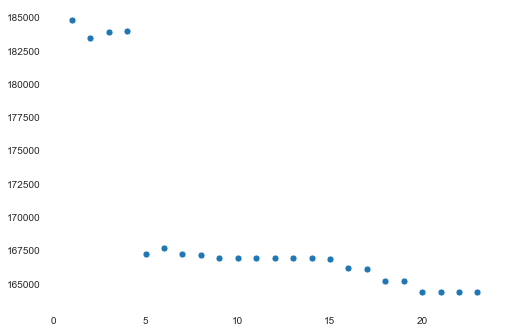

In [151]:
import seaborn as sns

sns.scatterplot(range(1, X_train_enc.shape[1]+1), mae_list);

In [135]:
#  Fit a ridge regression model with multiple features. 

# Use the normalize=True parameter 
# (or do feature scaling beforehand — 
# use the scaler's fit_transform method with the train set, and the scaler's transform method with the test set)

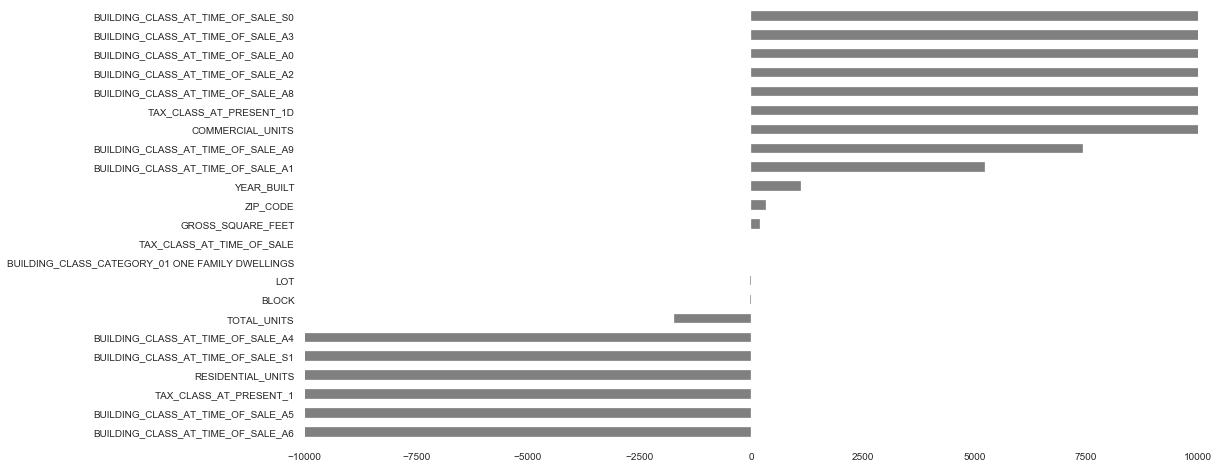

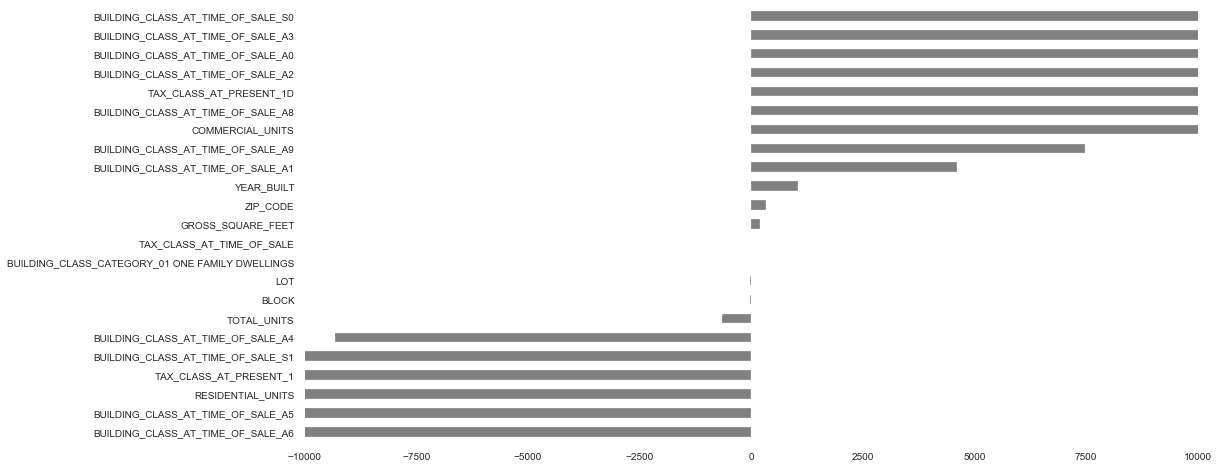

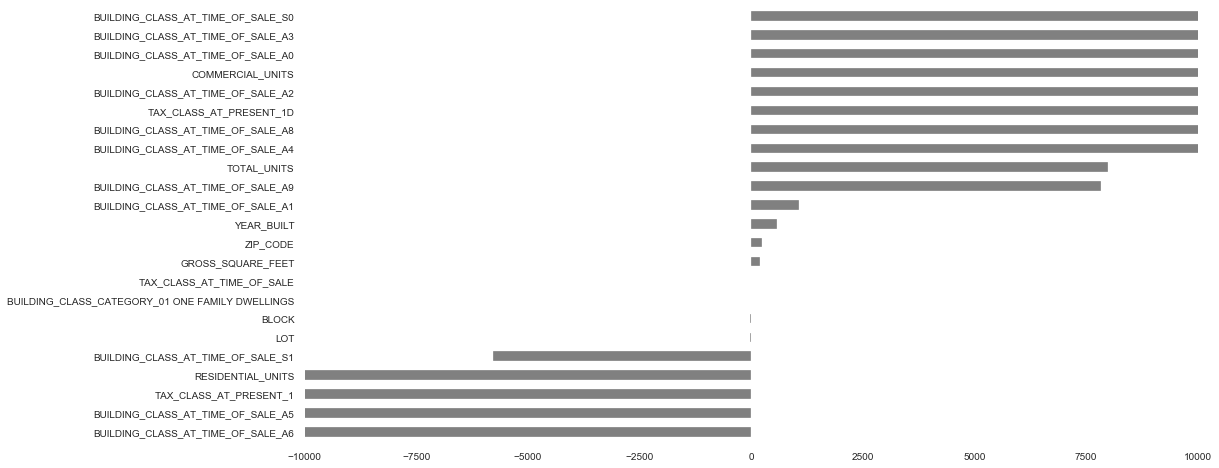

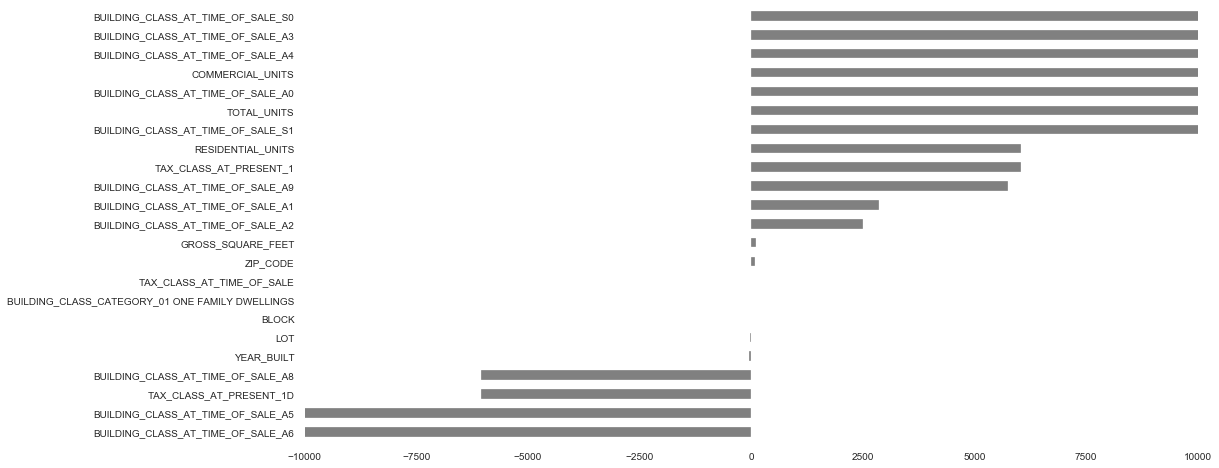

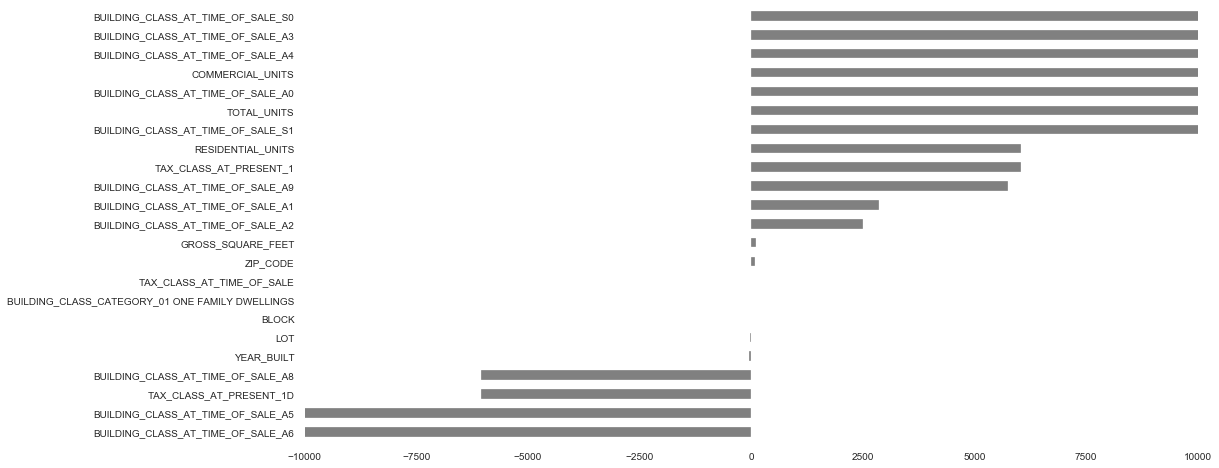

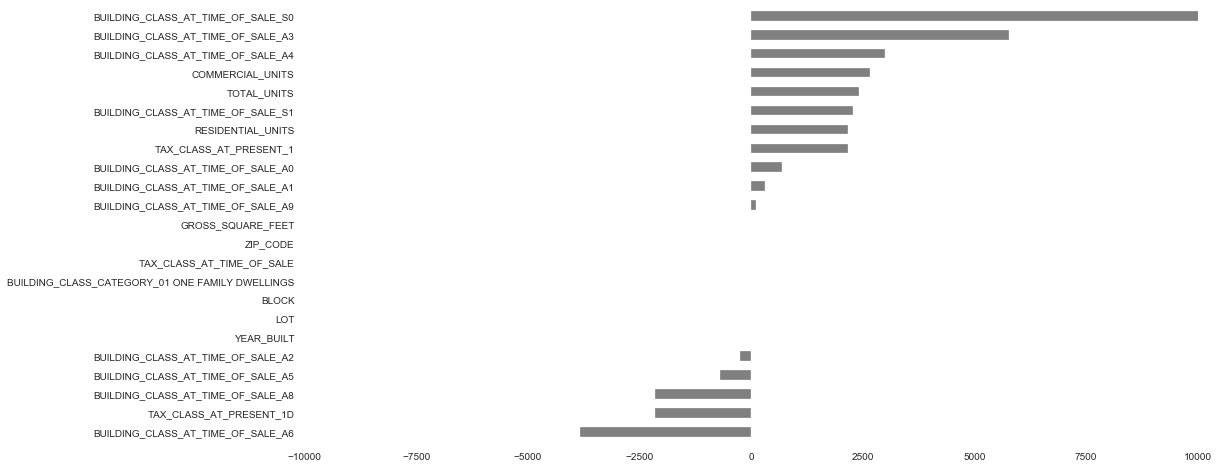

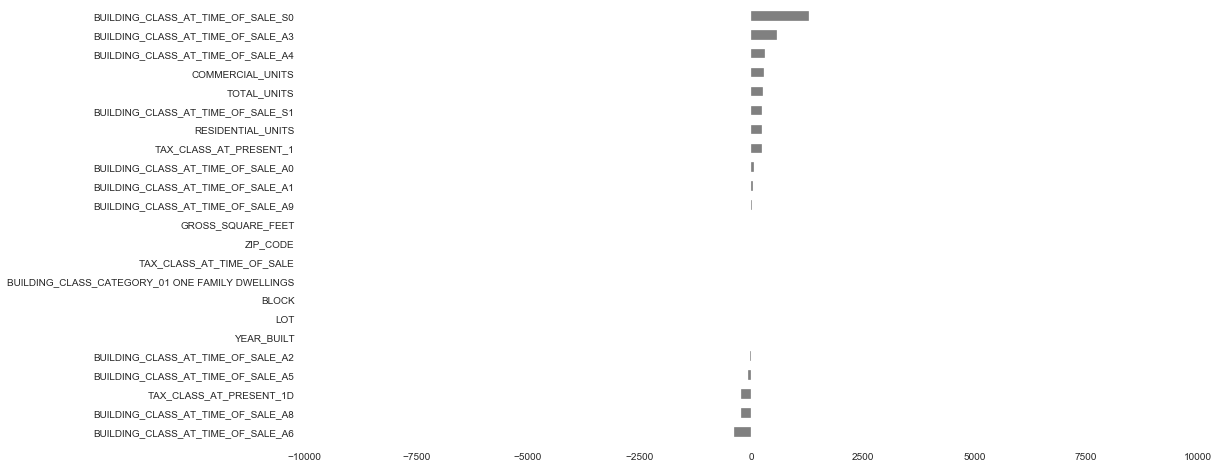

In [153]:
import matplotlib.pyplot as plt
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge

from IPython.display import display, HTML

# Try a range of alpha parameters for Ridge Regression.

# The scikit-learn docs explain, 
# alpha : Regularization strength; must be a positive float. Regularization 
# improves the conditioning of the problem and reduces the variance of the 
# estimates. Larger values specify stronger regularization.
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

for alpha in [0.001, 0.01, 0.1, 1.0, 1, 100.0, 1000.0]:
    
    # Fit Ridge Regression model
    display(HTML(f'Ridge Regression, with alpha={alpha}'))
    model = Ridge(alpha=alpha, normalize=True)
    model.fit(X_train_enc, y_train)
    y_pred = model.predict(X_test_enc)

    # Get Test MAE
    mae = mean_absolute_error(y_test, y_pred)
    display(HTML(f'Test Mean Absolute Error: ${mae:,.0f}'))
    
    # Plot coefficients
    coefficients = pd.Series(model.coef_, X_train_enc.columns)
    plt.figure(figsize=(16,8))
    coefficients.sort_values().plot.barh(color='grey')
    plt.xlim(-10000,10000)
    plt.show()

In [136]:
#  Get mean absolute error for the test set.

In [ ]:
# See above